In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install torch transformers datasets peft evaluate scikit-learn numpy pandas matplotlib seaborn bitsandbytes tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
import os
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    PeftModel
)
import evaluate
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [3]:
model_name = "microsoft/phi-2"

In [4]:
data_file_path = './invoices_500.json'

try:
    with open(data_file_path, 'r') as f:
        invoice_data = json.load(f)
    print(f"Successfully loaded {len(invoice_data)} examples from {data_file_path}")

    print("\nSample invoice data:")
    sample_idx = 0
    print(f"Input (truncated):\n{invoice_data[sample_idx]['input'][:200]}...\n")
    print(f"Expected Output (sample):\n{json.dumps(invoice_data[sample_idx]['output'], indent=2)[:200]}...\n")

except FileNotFoundError:
    print(f"Error: The file {data_file_path} was not found.")
    print("Please ensure the dataset file exists in the correct location.")
    raise
except json.JSONDecodeError:
    print(f"Error: The file {data_file_path} is not a valid JSON file.")
    raise
except Exception as e:
    print(f"An unexpected error occurred: {str(e)}")
    raise

Successfully loaded 500 examples from ./invoices_500.json

Sample invoice data:
Input (truncated):
11117 Campbell Brooks Apt. 246

Elizabethside, AK 00799

 

 

 

 

Description Quantity Unit price
redefine cross-media
systems 7.65 82.78
exploit bleeding-edge
action-items 7.0 59.16
incubate real-...

Expected Output (sample):
{
  "buyer": {
    "address": "65302 Booker Trafficway Apt. 529 Christophermouth, WY 67659"
  },
  "invoice": {
    "bc_no": "lo11165",
    "date": "05.04.1994",
    "maturity_date": "30.04.2008",
   ...



## Dataset preprocessing

In [5]:
def preprocess_data(data):
    processed_data = []

    for item in data:
        instruction = "Extract the structured information from this invoice and format it as JSON:"
        input_text = item["input"]

        output_text = json.dumps(item["output"], indent=2)

        prompt = f"{instruction}\n\n{input_text}"

        processed_data.append({
            "instruction": instruction,
            "input": input_text,
            "output": output_text,
            "prompt": prompt
        })

    return processed_data

In [6]:
processed_data = preprocess_data(invoice_data)

In [7]:
train_data, val_data = train_test_split(processed_data, test_size=0.1, random_state=42)
print(f"Training examples: {len(train_data)}, Validation examples: {len(val_data)}")

Training examples: 450, Validation examples: 50


In [8]:
train_dataset = Dataset.from_dict({
    "instruction": [item["instruction"] for item in train_data],
    "input": [item["input"] for item in train_data],
    "output": [item["output"] for item in train_data],
    "prompt": [item["prompt"] for item in train_data]
})

val_dataset = Dataset.from_dict({
    "instruction": [item["instruction"] for item in val_data],
    "input": [item["input"] for item in val_data],
    "output": [item["output"] for item in val_data],
    "prompt": [item["prompt"] for item in val_data]
})

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
def tokenization_function(examples):
    prompts = []
    targets = []

    for instruction, input_text, output_text in zip(
        examples["instruction"], examples["input"], examples["output"]
    ):
        prompt = f"{instruction}\n\n{input_text}\n\nJSON Result:\n"
        target = f"{prompt}{output_text}{tokenizer.eos_token}"

        prompts.append(prompt)
        targets.append(target)

    tokenized_targets = tokenizer(
        targets,
        padding="max_length",
        truncation=True,
        max_length=1536,
        return_tensors="pt"
    )

    tokenized_prompts = tokenizer(
        prompts,
        padding="max_length",
        truncation=True,
        max_length=1536,
        return_tensors="pt"
    )

    labels = tokenized_targets["input_ids"].clone()

    for i, (prompt_len, target_len) in enumerate(zip(
        tokenized_prompts["attention_mask"].sum(dim=1),
        tokenized_targets["attention_mask"].sum(dim=1)
    )):
        labels[i, :prompt_len] = -100

    tokenized_targets["labels"] = labels

    return tokenized_targets

tokenized_train_dataset = train_dataset.map(
    tokenization_function,
    batched=True,
    remove_columns=["instruction", "input", "output", "prompt"]
)

tokenized_val_dataset = val_dataset.map(
    tokenization_function,
    batched=True,
    remove_columns=["instruction", "input", "output", "prompt"]
)

print("Tokenization complete")

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Tokenization complete


## LoRA fine-tuning for Phi

In [12]:
print("Setting up model for LoRA fine-tuning...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "fc1",
        "fc2"
    ]
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

training_args = TrainingArguments(
    output_dir="./phi2-invoice-extraction",
    eval_strategy="steps",
    eval_steps=40,
    save_strategy="steps",
    save_steps=80,
    learning_rate=5e-4,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=2,
    weight_decay=0.01,
    warmup_steps=10,
    logging_steps=10,
    fp16=True,
    load_best_model_at_end=True,
    gradient_accumulation_steps=4,
    max_grad_norm=0.3,
    report_to="none",
    optim="paged_adamw_32bit"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
)

print("Starting training...")
trainer.train()

model.save_pretrained("./phi2-invoice-lora-adapter")
print("Model fine-tuning completed and saved!")

Setting up model for LoRA fine-tuning...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-12-4492503216de>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 6,553,600 || all params: 2,786,237,440 || trainable%: 0.2352
Starting training...


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
40,0.938700,0.874214
80,0.765600,0.763452


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Model fine-tuning completed and saved!


## Evaluation Metrics after fine-tunning with LoRa

In [13]:
def clean_and_parse_json(text):
    if "JSON Result:" in text:
        try:
            json_text = text.split("JSON Result:")[1].strip()
            return json.loads(json_text)
        except json.JSONDecodeError:
            try:
                import re
                json_text = re.sub(r',\s*}', '}', json_text)
                json_text = re.sub(r',\s*]', ']', json_text)
                json_text = re.sub(r'(\w+)(?=\s*:)', r'"\1"', json_text)
                return json.loads(json_text)
            except (json.JSONDecodeError, NameError):
                return {}
    return {}

def evaluate_json_extraction(original, predicted):
    if isinstance(original, str):
        try:
            original = json.loads(original)
        except json.JSONDecodeError:
            original = {}

    if isinstance(predicted, str):
        try:
            predicted = json.loads(predicted)
        except json.JSONDecodeError:
            predicted = {}

    def flatten_dict(d, parent_key='', sep='.'):
        items = []
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            if isinstance(v, dict):
                items.extend(flatten_dict(v, new_key, sep=sep).items())
            elif isinstance(v, list) and all(isinstance(i, dict) for i in v):
                for i, item in enumerate(v):
                    list_key = f"{new_key}[{i}]"
                    items.extend(flatten_dict(item, list_key, sep=sep).items())
            else:
                items.append((new_key, v))
        return dict(items)

    flat_original = flatten_dict(original)
    flat_predicted = flatten_dict(predicted)

    all_keys = set(flat_original.keys())
    found_keys = set(flat_original.keys()).intersection(set(flat_predicted.keys()))

    exact_matches = 0
    field_accuracy = {}

    for key in all_keys:
        if key in flat_predicted and flat_original[key] == flat_predicted[key]:
            exact_matches += 1
            field_accuracy[key] = 1.0
        else:
            field_accuracy[key] = 0.0

    results = {
        "exact_match": exact_matches,
        "fields_found": len(found_keys),
        "total_fields": len(all_keys),
        "field_accuracy": field_accuracy,
        "overall_accuracy": exact_matches / len(all_keys) if all_keys else 0
    }

    return results

eval_examples = val_dataset.select(range(min(5, len(val_dataset))))

def generate_extraction(model, tokenizer, prompt, max_length=1536):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=max_length,
            temperature=0.1,
            top_p=0.75,
            do_sample=False
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    result_prefix = "JSON Result:"
    if result_prefix in generated_text:
        extraction = generated_text.split(result_prefix)[1].strip()
    else:
        extraction = generated_text.strip()

    try:
        json_result = json.loads(extraction)
        extraction = json.dumps(json_result, indent=2)
    except json.JSONDecodeError:
        pass

    return extraction

print("Evaluating fine-tuned model...")

results = {
    "overall_accuracy": [],
    "fields_found_pct": [],
    "exact_match_pct": [],
    "field_accuracies": {}
}

for example in tqdm(eval_examples):
    prompt = f"{example['instruction']}\n\n{example['input']}\n\nJSON Result:\n"

    predicted_output = generate_extraction(model, tokenizer, prompt)

    try:
        predicted_json = json.loads(predicted_output)
    except json.JSONDecodeError:
        predicted_json = {}

    try:
        expected_json = json.loads(example["output"])
    except json.JSONDecodeError:
        expected_json = {}

    eval_result = evaluate_json_extraction(expected_json, predicted_json)

    results["overall_accuracy"].append(eval_result["overall_accuracy"])
    results["fields_found_pct"].append(eval_result["fields_found"] / eval_result["total_fields"])
    results["exact_match_pct"].append(eval_result["exact_match"] / eval_result["total_fields"])

    for field, accuracy in eval_result["field_accuracy"].items():
        if field not in results["field_accuracies"]:
            results["field_accuracies"][field] = []
        results["field_accuracies"][field].append(accuracy)

    print(f"\n--- Example Evaluation ---")
    print(f"Input: {example['input'][:100]}...")
    print(f"Expected (truncated): {example['output'][:100]}...")
    print(f"Predicted (truncated): {predicted_output[:100]}...")
    print(f"Accuracy: {eval_result['overall_accuracy']:.2f}")

avg_accuracy = np.mean(results["overall_accuracy"])
avg_fields_found = np.mean(results["fields_found_pct"])
avg_exact_match = np.mean(results["exact_match_pct"])

print(f"\n--- Overall Evaluation Results ---")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Fields Found: {avg_fields_found:.4f}")
print(f"Average Exact Match: {avg_exact_match:.4f}")

category_accuracy = {}
for field in results["field_accuracies"]:
    category = field.split('.')[0] if '.' in field else field.split('[')[0] if '[' in field else field
    if category not in category_accuracy:
        category_accuracy[category] = []
    category_accuracy[category].extend(results["field_accuracies"][field])

print("\n--- Category-specific Accuracy ---")
for category, accuracies in category_accuracy.items():
    print(f"{category}: {np.mean(accuracies):.4f}")

Evaluating fine-tuned model...


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.75` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Example Evaluation ---
Input: 17400 Katherine Trafficway
East Jennifer, OK 78357 - Malawi

927-966-8407x281 - http://clark.com/

V...
Expected (truncated): {
  "buyer": {
    "address": "5411 Hughes Shores Lopezmouth, TN 39998",
    "company_name": "Burges...
Predicted (truncated): {
  "buyer": {
    "address": "5411 Hughes Shores Lopezmouth, TN 39998",
    "company_name": "Burges...
Accuracy: 0.97


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Example Evaluation ---
Input: 618 Kathleen Crescent
Nicholasville, Hl 92568 - Saint Martin

394-390-3147 - https://gregory-ortiz.i...
Expected (truncated): {
  "buyer": {
    "address": "14625 Giles Rapids South Jason, WY 82211",
    "company_name": "Wilso...
Predicted (truncated): {
  "buyer": {
    "address": "14625 Giles Rapids South Jason, WY 82211",
    "company_name": "Wilso...
Accuracy: 0.90


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Example Evaluation ---
Input: 6410 Larsen Rapid Apt. 009
Port Karenchester, FM 32025 BILL

Invoice number
723970

Date Maturity Bc...
Expected (truncated): {
  "buyer": {
    "address": "4753 Jackson Mews Johnnyview, MA 98335"
  },
  "invoice": {
    "bc_n...
Predicted (truncated): {
  "buyer": {
    "address": "4753 Jackson Mews Johnnyview, MA 98335"
  },
  "invoice": {
    "bc_n...
Accuracy: 1.00


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Example Evaluation ---
Input: 788 Rebecca Light Apt. 638
Laneview, MO 18848 - Togo

+1-299-211-5120x98353 - https://www.mercer.net...
Expected (truncated): {
  "buyer": {
    "address": "04649 Henderson Valleys Suite 711 North Mario, MD 52299",
    "compan...
Predicted (truncated): {
  "buyer": {
    "address": "04649 Henderson Valleys Suite 711 North Mario, MD 52299",
    "compan...
Accuracy: 0.98

--- Example Evaluation ---
Input: 507 Joshua Mount Apt. 576
Lake Michelle, IN 34904 - Armenia

876.543.4295x38976 - https://stewart.in...
Expected (truncated): {
  "buyer": {
    "address": "7742 Cassandra Summit Suite 568 Port Jessica, VT 79420",
    "company...
Predicted (truncated): {
  "buyer": {
    "address": "7742 Cassandra Summit Suite 568 Port Jessica, VT 79420",
    "company...
Accuracy: 0.95

--- Overall Evaluation Results ---
Average Accuracy: 0.9597
Average Fields Found: 1.0000
Average Exact Match: 0.9597

--- Category-specific Accuracy ---
products[3]: 1.0000
seller: 0.85

In [27]:
#!cp -r /content/phi2-invoice-extraction /content/drive/MyDrive
#!cp -r /content/phi2-invoice-lora-adapter /content/drive/MyDrive
!cp -r /content/phi2-invoice-extractor-final /content/drive/MyDrive

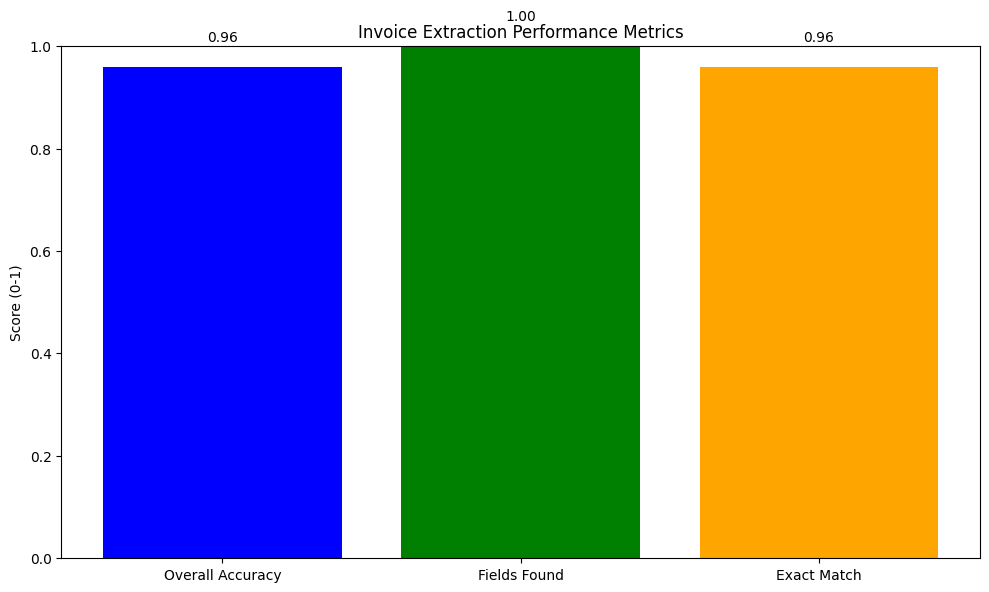

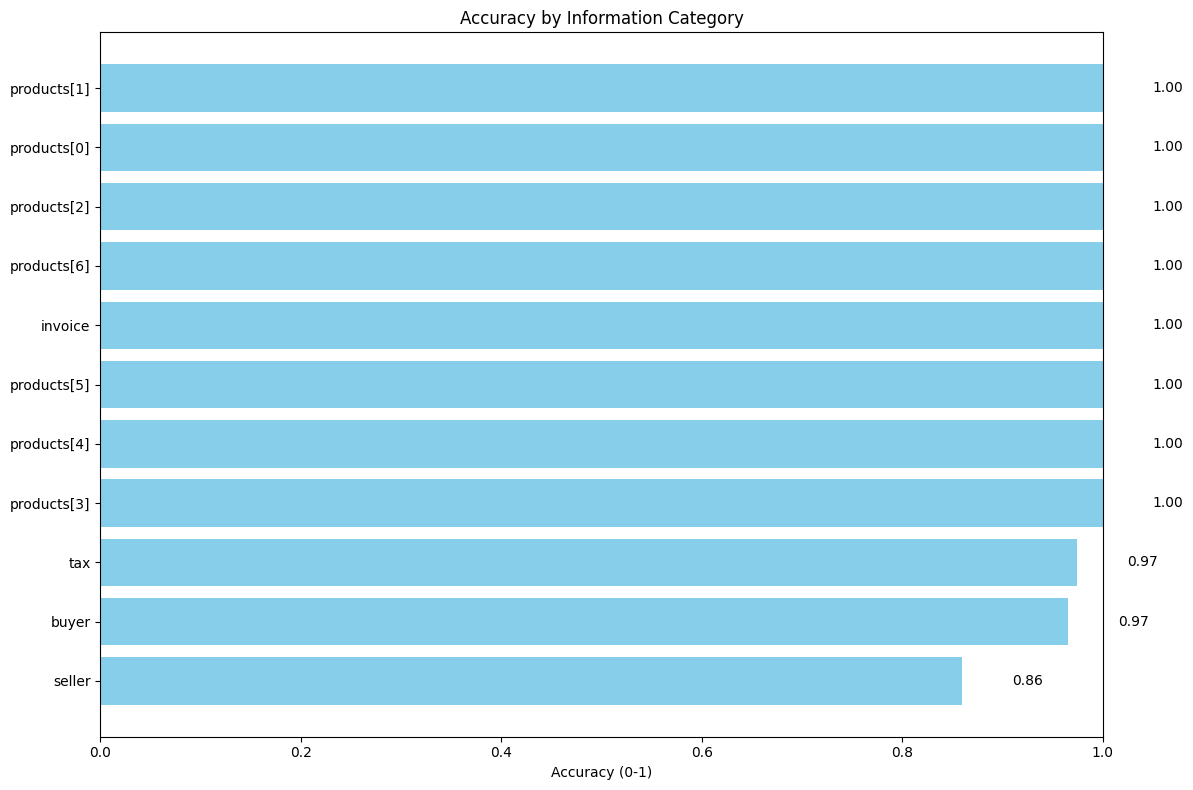

In [18]:
plt.figure(figsize=(10, 6))
metrics = ['Overall Accuracy', 'Fields Found', 'Exact Match']
values = [avg_accuracy, avg_fields_found, avg_exact_match]
plt.bar(metrics, values, color=['blue', 'green', 'orange'])
plt.title('Invoice Extraction Performance Metrics')
plt.ylabel('Score (0-1)')
plt.ylim(0, 1)

for i, v in enumerate(values):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()
plt.savefig('overall_metrics.png')
plt.close()

plt.figure(figsize=(12, 8))
categories = list(category_accuracy.keys())
category_values = [np.mean(category_accuracy[cat]) for cat in categories]

sorted_indices = np.argsort(category_values)
sorted_categories = [categories[i] for i in sorted_indices]
sorted_values = [category_values[i] for i in sorted_indices]

plt.barh(sorted_categories, sorted_values, color='skyblue')
plt.title('Accuracy by Information Category')
plt.xlabel('Accuracy (0-1)')
plt.xlim(0, 1)

for i, v in enumerate(sorted_values):
    plt.text(v + 0.05, i, f'{v:.2f}', va='center')

plt.tight_layout()
plt.show()
plt.savefig('category_accuracy.png')
plt.close()

## Evaluation Metrics before fine-tunning

In [17]:
print("Loading base Phi-2 model for comparison...")

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

print("Evaluating base Phi-2 model...")

def evaluate_base_model(base_model, tokenizer, eval_examples):
    base_results = {
        "overall_accuracy": [],
        "fields_found_pct": [],
        "exact_match_pct": [],
        "field_accuracies": {}
    }

    for example in tqdm(eval_examples):
        prompt = f"{example['instruction']}\n\n{example['input']}\n\nJSON Result:\n"

        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = base_model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=2048,
                temperature=0.1,
                top_p=0.75,
                do_sample=False
            )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        result_prefix = "JSON Result:"
        if result_prefix in generated_text:
            extraction = generated_text.split(result_prefix)[1].strip()
        else:
            extraction = generated_text.strip()

        try:
            predicted_json = json.loads(extraction)
        except json.JSONDecodeError:
            predicted_json = {}

        try:
            expected_json = json.loads(example["output"])
        except json.JSONDecodeError:
            expected_json = {}

        eval_result = evaluate_json_extraction(expected_json, predicted_json)

        base_results["overall_accuracy"].append(eval_result["overall_accuracy"])
        base_results["fields_found_pct"].append(eval_result["fields_found"] / eval_result["total_fields"])
        base_results["exact_match_pct"].append(eval_result["exact_match"] / eval_result["total_fields"])

        for field, accuracy in eval_result["field_accuracy"].items():
            if field not in base_results["field_accuracies"]:
                base_results["field_accuracies"][field] = []
            base_results["field_accuracies"][field].append(accuracy)

        print(f"\n--- Base Model Example Evaluation ---")
        print(f"Input: {example['input'][:100]}...")
        print(f"Expected (truncated): {example['output'][:100]}...")
        print(f"Predicted (truncated): {extraction[:100]}...")
        print(f"Accuracy: {eval_result['overall_accuracy']:.2f}")

    return base_results

eval_examples = val_dataset.select(range(min(5, len(val_dataset))))
base_results = evaluate_base_model(base_model, tokenizer, eval_examples)

base_avg_accuracy = np.mean(base_results["overall_accuracy"])
base_avg_fields_found = np.mean(base_results["fields_found_pct"])
base_avg_exact_match = np.mean(base_results["exact_match_pct"])

print(f"\n--- Base Model Overall Evaluation Results ---")
print(f"Average Accuracy: {base_avg_accuracy:.4f}")
print(f"Average Fields Found: {base_avg_fields_found:.4f}")
print(f"Average Exact Match: {base_avg_exact_match:.4f}")

base_category_accuracy = {}
for field in base_results["field_accuracies"]:
    category = field.split('.')[0] if '.' in field else field.split('[')[0] if '[' in field else field
    if category not in base_category_accuracy:
        base_category_accuracy[category] = []
    base_category_accuracy[category].extend(base_results["field_accuracies"][field])

print("\n--- Base Model Category-specific Accuracy ---")
for category, accuracies in base_category_accuracy.items():
    print(f"{category}: {np.mean(accuracies):.4f}")

print("\n--- Performance Comparison: Base vs Fine-tuned ---")
metrics_comparison = {
    "Metric": ["Overall Accuracy", "Fields Found", "Exact Match"],
    "Base Phi-2": [base_avg_accuracy, base_avg_fields_found, base_avg_exact_match],
    "Fine-tuned Phi-2": [avg_accuracy, avg_fields_found, avg_exact_match],
    "Improvement": [avg_accuracy - base_avg_accuracy,
                  avg_fields_found - base_avg_fields_found,
                  avg_exact_match - base_avg_exact_match]
}

comparison_df = pd.DataFrame(metrics_comparison)
print(comparison_df.to_string(index=False, float_format="{:.4f}".format))

all_categories = set(list(category_accuracy.keys()) + list(base_category_accuracy.keys()))
print("\n--- Category-specific Performance Comparison ---")

category_comparison = {
    "Category": [],
    "Base Phi-2": [],
    "Fine-tuned Phi-2": [],
    "Improvement": []
}

for category in all_categories:
    base_acc = np.mean(base_category_accuracy.get(category, [0]))
    ft_acc = np.mean(category_accuracy.get(category, [0]))
    improvement = ft_acc - base_acc

    category_comparison["Category"].append(category)
    category_comparison["Base Phi-2"].append(base_acc)
    category_comparison["Fine-tuned Phi-2"].append(ft_acc)
    category_comparison["Improvement"].append(improvement)

category_df = pd.DataFrame(category_comparison)
category_df = category_df.sort_values(by="Improvement", ascending=False)
print(category_df.to_string(index=False, float_format="{:.4f}".format))

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading base Phi-2 model for comparison...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating base Phi-2 model...


  0%|          | 0/5 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Base Model Example Evaluation ---
Input: 17400 Katherine Trafficway
East Jennifer, OK 78357 - Malawi

927-966-8407x281 - http://clark.com/

V...
Expected (truncated): {
  "buyer": {
    "address": "5411 Hughes Shores Lopezmouth, TN 39998",
    "company_name": "Burges...
Predicted (truncated): {
    "invoice_number": "0oD-4548-3218",
    "invoice_date": "29.10.1994",
    "delivery_address": "...
Accuracy: 0.00


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Base Model Example Evaluation ---
Input: 618 Kathleen Crescent
Nicholasville, Hl 92568 - Saint Martin

394-390-3147 - https://gregory-ortiz.i...
Expected (truncated): {
  "buyer": {
    "address": "14625 Giles Rapids South Jason, WY 82211",
    "company_name": "Wilso...
Predicted (truncated): {
  "invoice_number": "Qe-6086-6080",
  "invoice_date": "04.01.1999",
  "delivery_address": "Wilson-...
Accuracy: 0.00


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Base Model Example Evaluation ---
Input: 6410 Larsen Rapid Apt. 009
Port Karenchester, FM 32025 BILL

Invoice number
723970

Date Maturity Bc...
Expected (truncated): {
  "buyer": {
    "address": "4753 Jackson Mews Johnnyview, MA 98335"
  },
  "invoice": {
    "bc_n...
Predicted (truncated): {
  "invoice_number": "723970",
  "date_maturity_bc_no": "28.12.2013 17.02.2018",
  "date": "28.12.2...
Accuracy: 0.00


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Base Model Example Evaluation ---
Input: 788 Rebecca Light Apt. 638
Laneview, MO 18848 - Togo

+1-299-211-5120x98353 - https://www.mercer.net...
Expected (truncated): {
  "buyer": {
    "address": "04649 Henderson Valleys Suite 711 North Mario, MD 52299",
    "compan...
Predicted (truncated): {
  "invoice_number": "OA-8232-1207",
  "invoice_date": "10.06.2003",
  "customer_name": "Mercer",
 ...
Accuracy: 0.00

--- Base Model Example Evaluation ---
Input: 507 Joshua Mount Apt. 576
Lake Michelle, IN 34904 - Armenia

876.543.4295x38976 - https://stewart.in...
Expected (truncated): {
  "buyer": {
    "address": "7742 Cassandra Summit Suite 568 Port Jessica, VT 79420",
    "company...
Predicted (truncated): {
    "invoice_number": "cK-0082-8038",
    "invoice_date": "04.08.2003",
    "delivery_address": "B...
Accuracy: 0.00

--- Base Model Overall Evaluation Results ---
Average Accuracy: 0.0000
Average Fields Found: 0.0000
Average Exact Match: 0.0000

--- Base Model Category-specific A

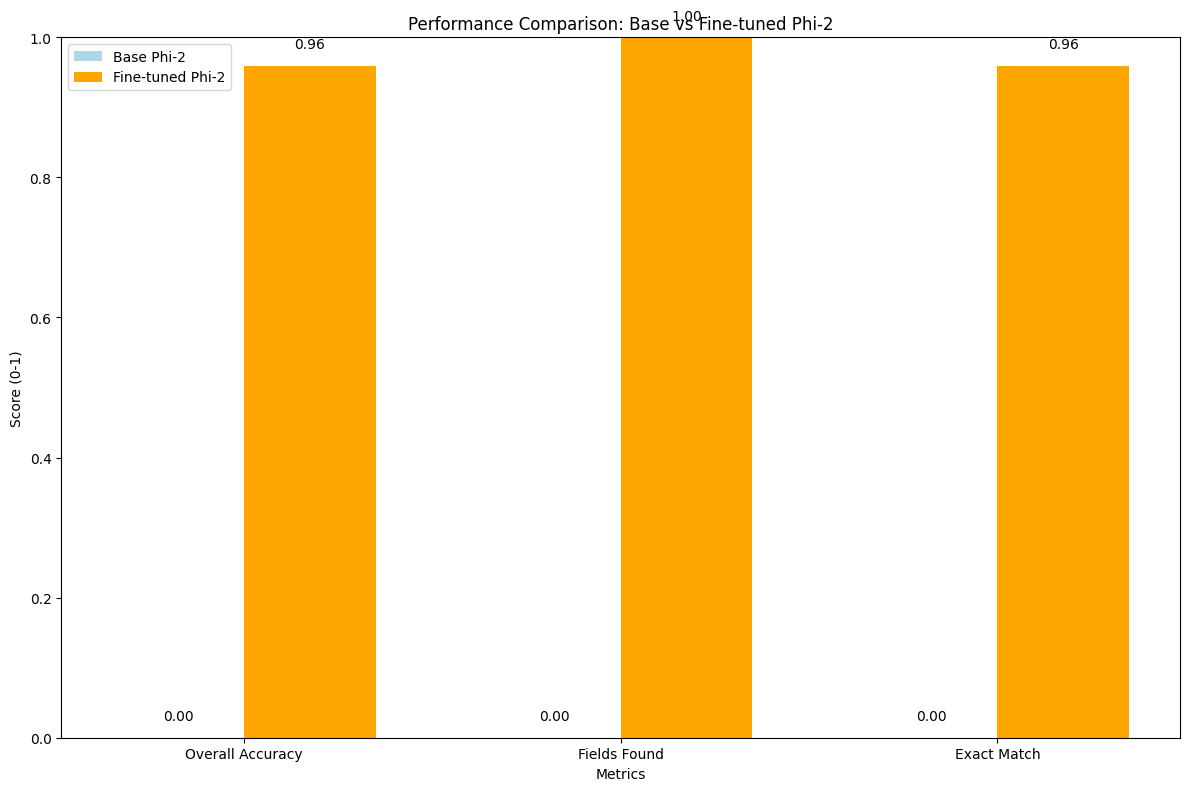

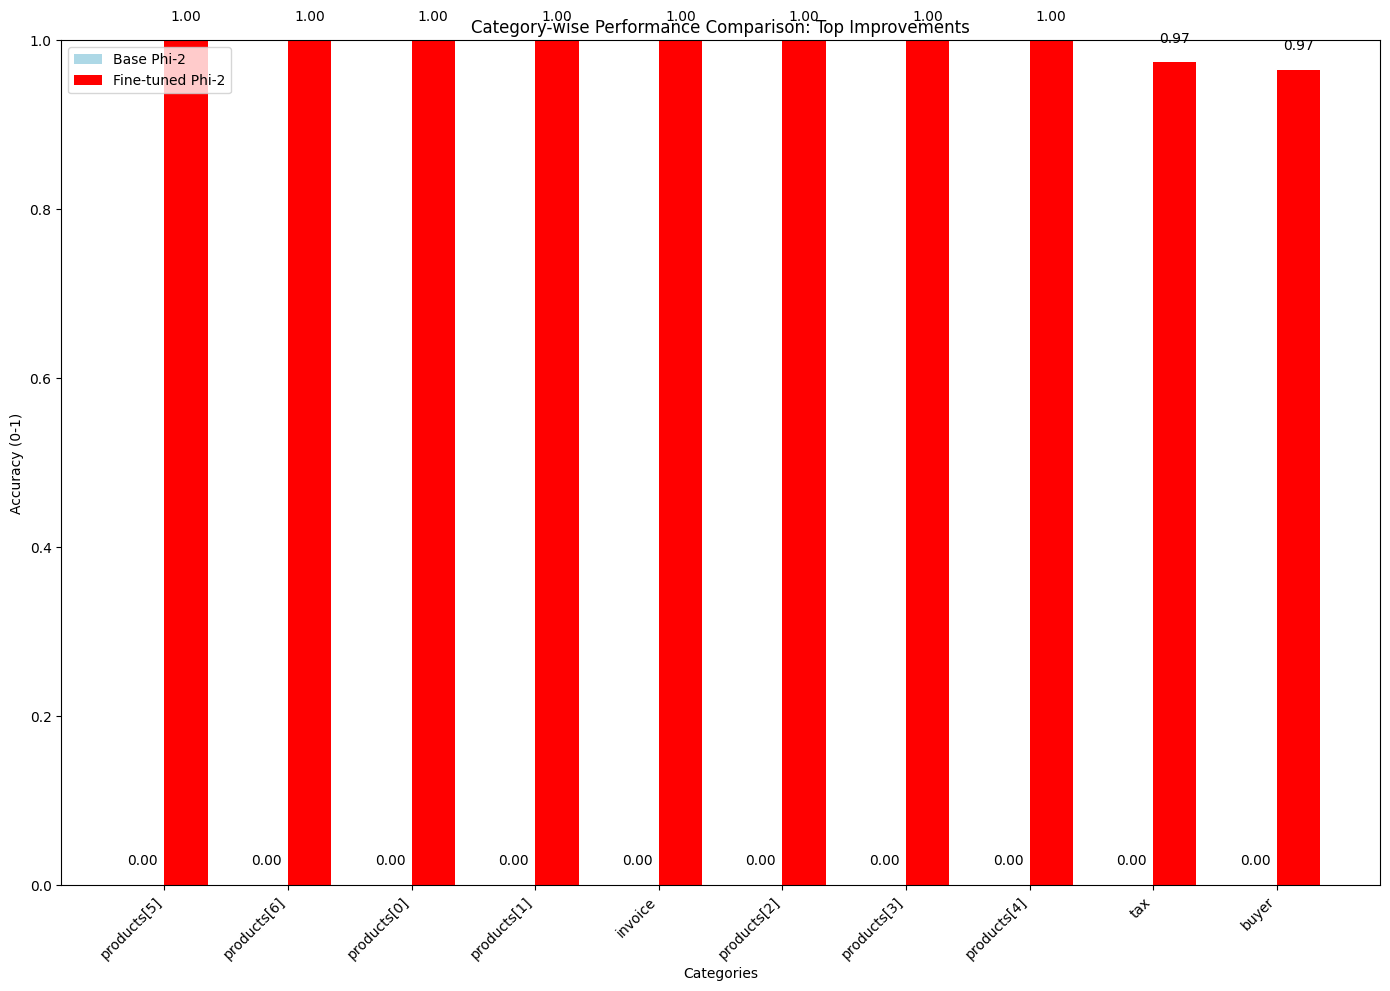

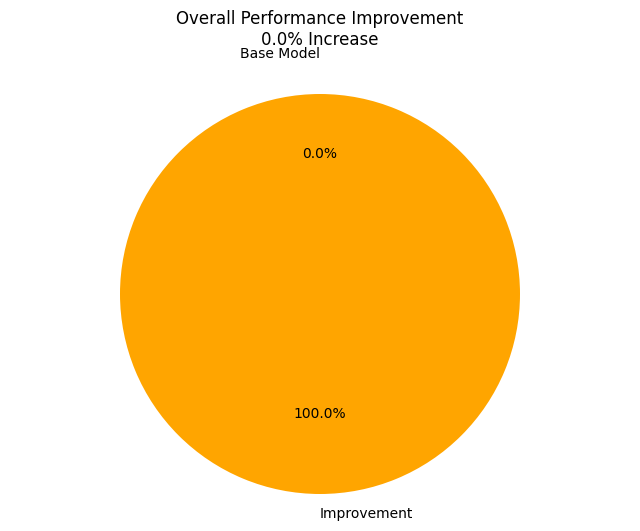

In [22]:
plt.figure(figsize=(12, 8))

metrics = ['Overall Accuracy', 'Fields Found', 'Exact Match']
bar_width = 0.35
x = np.arange(len(metrics))

base_bars = plt.bar(x - bar_width/2,
                   [base_avg_accuracy, base_avg_fields_found, base_avg_exact_match],
                   bar_width,
                   label='Base Phi-2',
                   color='lightblue')

finetuned_bars = plt.bar(x + bar_width/2,
                        [avg_accuracy, avg_fields_found, avg_exact_match],
                        bar_width,
                        label='Fine-tuned Phi-2',
                        color='orange')

plt.xlabel('Metrics')
plt.ylabel('Score (0-1)')
plt.title('Performance Comparison: Base vs Fine-tuned Phi-2')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom')

add_labels(base_bars)
add_labels(finetuned_bars)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

plt.figure(figsize=(14, 10))

top_n = min(10, len(category_df))
top_categories = category_df.head(top_n)

x = np.arange(len(top_categories))

base_bars = plt.bar(x - bar_width/2, top_categories["Base Phi-2"],
                   bar_width, label='Base Phi-2', color='lightblue')
ft_bars = plt.bar(x + bar_width/2, top_categories["Fine-tuned Phi-2"],
                 bar_width, label='Fine-tuned Phi-2', color='red')

plt.xlabel('Categories')
plt.ylabel('Accuracy (0-1)')
plt.title('Category-wise Performance Comparison: Top Improvements')
plt.xticks(x, top_categories["Category"], rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()

add_labels(base_bars)
add_labels(ft_bars)

plt.tight_layout()
plt.savefig('category_comparison.png')
plt.show()

avg_base_performance = np.mean([base_avg_accuracy, base_avg_fields_found, base_avg_exact_match])
avg_ft_performance = np.mean([avg_accuracy, avg_fields_found, avg_exact_match])
improvement_percentage = ((avg_ft_performance - avg_base_performance) / avg_base_performance) * 100 if avg_base_performance > 0 else 0

plt.figure(figsize=(8, 6))
plt.pie([avg_base_performance, avg_ft_performance - avg_base_performance],
       labels=['Base Model', 'Improvement'],
       colors=['lightblue', 'orange'],
       autopct='%1.1f%%',
       startangle=90,
       explode=(0, 0.1))
plt.axis('equal')
plt.title(f'Overall Performance Improvement\n{improvement_percentage:.1f}% Increase')
plt.savefig('improvement_percentage.png')
plt.show()

## Structured Output

In [30]:
import re
import json

def clean_json_for_parsing(json_str):
    pattern = r':\s*([\d,]+\.\d+)'
    json_str = re.sub(pattern, lambda m: ': ' + m.group(1).replace(',', ''), json_str)

    pattern = r':\s*([\d,]+)(?=\s*[,\}])'
    json_str = re.sub(pattern, lambda m: ': ' + m.group(1).replace(',', ''), json_str)

    json_str = re.sub(r',\s*}', '}', json_str)

    json_str = re.sub(r',\s*\]', ']', json_str)

    return json_str

def parse_json_safely(json_str):
    try:
        return json.loads(json_str), True
    except json.JSONDecodeError:
        try:
            cleaned_json = clean_json_for_parsing(json_str)
            return json.loads(cleaned_json), True
        except json.JSONDecodeError as e:
            return {
                "error": "Could not parse JSON",
                "message": str(e),
                "raw_text": json_str[:500] + ("..." if len(json_str) > 500 else "")
            }, False

def flatten_for_dataframe(nested_dict, prefix=''):
    flat_dict = {}
    for key, value in nested_dict.items():
        if isinstance(value, dict):
            flat_dict.update(flatten_for_dataframe(value, f"{prefix}{key}_"))
        elif isinstance(value, list) and len(value) > 0 and isinstance(value[0], dict):
            flat_dict.update(flatten_for_dataframe(value[0], f"{prefix}{key}_item0_"))
        else:
            flat_dict[f"{prefix}{key}"] = value
    return flat_dict

def demo_invoice_extraction(model, tokenizer, input_text):
    instruction = "Extract the structured information from this invoice and format it as JSON:"
    prompt = f"{instruction}\n\n{input_text}\n\nJSON Result:\n"

    extraction = generate_extraction(model, tokenizer, prompt)

    structured_data, success = parse_json_safely(extraction)

    return {
        "input": input_text,
        "extracted_text": extraction,
        "structured_data": structured_data,
        "parsing_successful": success
    }

def batch_process_invoices(invoices, model, tokenizer):
    batch_results = []
    successes = 0

    for i, invoice in enumerate(invoices):
        print(f"Processing invoice {i+1}/{len(invoices)}...")
        result = demo_invoice_extraction(model, tokenizer, invoice)
        batch_results.append(result["structured_data"])
        if result["parsing_successful"]:
            successes += 1

    print(f"Successfully parsed {successes}/{len(invoices)} invoices")
    return batch_results

print("\n--- Structured Output with Improved Parsing ---")
result = demo_invoice_extraction(model, tokenizer, test_invoice)

print("Input Invoice (truncated):")
print(test_invoice[:200] + "...")
print("\nExtracted JSON:")
print(result["extracted_text"])
print("\nStructured Data (parsed JSON):")
print(json.dumps(result["structured_data"], indent=2))

print("\n--- Demo: Batch Processing with Improved Parsing ---")
test_invoices = [invoice_data[0]["input"], invoice_data[1]["input"], test_invoice]
batch_results = batch_process_invoices(test_invoices, model, tokenizer)

flat_batch_results = [flatten_for_dataframe(result) for result in batch_results]
batch_df = pd.DataFrame(flat_batch_results)

print("Batch Results (sample columns):")
display_columns = batch_df.columns[:5] if len(batch_df.columns) > 5 else batch_df.columns
print(batch_df[display_columns])

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.75` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Structured Output with Improved Parsing ---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Input Invoice (truncated):

TechSolutions Inc.
123 Innovation Drive
Silicon Valley, CA 94025

INVOICE #INV-2025-051
Date: April 15, 2025
Due Date: May 15, 2025

Bill To:
John Smith
123 Client Street
Clientville, CA 90210
Email:...

Extracted JSON:
{
  "buyer": {
    "address": "123 Client Street Clientville, CA 90210",
    "email": "john.smith@example.com",
    "name": "John Smith"
  },
  "invoice": {
    "date": "April 15, 2025",
    "due_date": "May 15, 2025",
    "number": "INV-2025-051"
  },
  "payment": {
    "method": "credit card",
    "net_amount": 30
  },
  "products": [
    {
      "amount": 99.99,
      "description": "Cloud Storage: Premium tier",
      "quantity": 1,
      "price": 99.99
    },
    {
      "amount": 199.99,
      "description": "Technical Support: 24/7",
      "quantity": 1,
      "price": 199.99
    },
    {
      "amount": 1499.95,
      "description": "Software License: Enterprise",
      "quantity": 5,
      "price": 299.99
    }
  ],
  "seller": {
   

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing invoice 2/3...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing invoice 3/3...
Successfully parsed 3/3 invoices
Batch Results (sample columns):
                                       buyer_address invoice_bc_no  \
0  65302 Booker Trafficway Apt. 529 Christophermo...       lo11165   
1  2233 Delgado Viaduct Suite 382 Brownborough, N...           NaN   
2            123 Client Street Clientville, CA 90210           NaN   

     invoice_date invoice_maturity_date invoice_number  
0      05.04.1994            30.04.2008         158485  
1      16.07.1995                   NaN         686851  
2  April 15, 2025                   NaN   INV-2025-051  


## Saving Fine-tuned Phi

In [26]:
import os
import json
import zipfile
from google.colab import files

model_save_dir = "./phi2-invoice-extractor-final"
os.makedirs(model_save_dir, exist_ok=True)

print("Saving the model and related files...")

model.save_pretrained(f"{model_save_dir}/lora_adapter")

tokenizer.save_pretrained(f"{model_save_dir}/tokenizer")

target_modules = list(peft_config.target_modules) if hasattr(peft_config.target_modules, '__iter__') else peft_config.target_modules

config_info = {
    "base_model": model_name,
    "date_created": "2025-05-11 22:33:56",
    "task": "Structured JSON Invoice Information Extraction",
    "training_examples": len(train_data),
    "validation_examples": len(val_data),
    "accuracy": float(avg_accuracy),
    "fields_extracted": list(category_accuracy.keys()),
    "lora_config": {
        "r": int(peft_config.r),
        "lora_alpha": float(peft_config.lora_alpha),
        "lora_dropout": float(peft_config.lora_dropout),
        "target_modules": target_modules
    }
}

with open(f"{model_save_dir}/model_info.json", "w") as f:
    json.dump(config_info, f, indent=2)

Saving the model and related files...
